In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [2]:
class model_performance:
    
    def __init__(self, model):
        self.model = model

    def rmse(self, X, y):
        prediction = self.model.predict(X)
        mse = mean_squared_error(y, prediction)
        rmse = np.sqrt(mse)
        return rmse
    
    def r2(self, X, y):
        prediction = self.model.predict(X)
        r2 = np.sqrt(r2_score((y),(prediction)))
        return r2
    
    def cross_validation_scores(self, X, y):
        scores = cross_val_score(self.model, X, y, scoring="neg_mean_squared_error", cv=10)
        scores = np.sqrt(-scores)
        return scores
          
    def print_metrics(self, X, y):
        print(f'RMSE: {self.rmse(X, y)}')
        print(f'R2: {self.r2(X, y)}')
        print('\nCross_validation:')
        print(f'Mean: {self.cross_validation_scores(X, y).mean()}')
        print(f'SD: {self.cross_validation_scores(X, y).std()}')

### Import the dataset saved after EDA

In [3]:
diamonds = pd.read_csv('diamonds_eda.csv')
diamonds.head()

,carat,cut,color,clarity,price,lenght_x,width_y,depth_z
0,0.23,Ideal,E,SI2,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,335,4.34,4.35,2.75


### Split dataset to train and test set

Create X and y

In [4]:
X = diamonds.drop('price', axis=1)
y = diamonds['price']

In [5]:
X.shape, y.shape

((53917, 7), (53917,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
X_train.head()

,carat,cut,color,clarity,lenght_x,width_y,depth_z
31745,0.35,Ideal,H,VVS1,4.55,4.58,2.78
20164,1.02,Very Good,F,VVS2,6.58,6.69,3.94
24520,1.52,Premium,D,SI1,7.55,7.51,4.50
42435,0.50,Ideal,E,SI1,5.09,5.13,3.15
10254,1.01,Premium,E,SI2,6.39,6.36,3.99


In [8]:
X_train.shape, y_train.shape

((43133, 7), (43133,))

### run Ordinal encoder on cut, color, clarity

In [9]:
categories = [['Fair', 'Good', 'Very Good', 'Ideal', 'Premium'],
             ['D', 'E', 'F', 'G', 'H', 'I', 'J'],
             ['I1','SI2', 'SI1', 'VS2',  'VS1', 'VVS2', 'VVS1', 'IF']]

In [10]:
obj_cols = ['cut', 'color', 'clarity']

In [11]:
ordinal_encoder = OrdinalEncoder(categories=categories)

In [12]:
X_train_cat = X_train[obj_cols]
X_test_cat = X_test[obj_cols]

In [13]:
ordinal_encoder.fit(X_train_cat)
X_train_oe = pd.DataFrame(ordinal_encoder.transform(X_train_cat))
X_test_oe = pd.DataFrame(ordinal_encoder.transform(X_test_cat))

In [14]:
X_train_oe.index = X_train.index
X_train_oe.columns = X_train_cat.columns

X_test_oe.index = X_test.index
X_test_oe.columns = X_test_cat.columns

### Normalise numerical variables with StandardScaler

In [15]:
num_X_train = X_train.drop(obj_cols, axis=1)
num_X_test = X_test.drop(obj_cols, axis=1)

In [16]:
scaler = StandardScaler()
num_X_train_scaled = pd.DataFrame(scaler.fit_transform(num_X_train))
num_X_train_scaled.columns = num_X_train.columns
num_X_train_scaled.index = num_X_train.index

num_X_test_scaled = pd.DataFrame(scaler.transform(num_X_test))
num_X_test_scaled.columns = num_X_test.columns
num_X_test_scaled.index = num_X_test.index

### Merge categorical and numerical variables

In [17]:
X_train = pd.concat([num_X_train_scaled, X_train_oe], axis=1)
X_test = pd.concat([num_X_test_scaled, X_test_oe], axis=1)

## Models

### Linear Regression

In [18]:
lm = LinearRegression()
lm_model = lm.fit(X_train, y_train)

In [19]:
model_eval = model_performance(lm_model)
model_eval.print_metrics(X_train, y_train)

RMSE: 1223.4991085861132
R2: 0.9521052065649455

Cross_validation:
Mean: 1223.7471260610243
SD: 33.300100013323586


### Polynomial regression

In [34]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)

In [35]:
X_train_poly = poly.fit_transform(X_train)
print(X_train_poly.shape)

(43133, 120)


In [36]:
pr_model = lm.fit(X_train_poly, y_train)

In [37]:
model_eval = model_performance(pr_model)
model_eval.print_metrics(X_train_poly, y_train)

RMSE: 604.780864300095
R2: 0.988511796480447

Cross_validation:
Mean: 689.2143960227008
SD: 112.00841564199085


In [23]:
lml = Lasso()

In [46]:
alpha = []
error = []
for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100), max_iter=5000)
    error.append(np.mean(cross_val_score(lml, X_train, y_train, scoring='neg_mean_absolute_error', cv=6)))

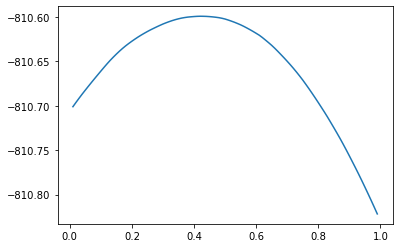

In [47]:
import matplotlib.pyplot as plt
plt.plot(alpha, error)

In [22]:
lml = Lasso(alpha=0.1, max_iter=10000)
lml.fit(X_test, y_test)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
model_eval = model_performance(lml)
model_eval.print_metrics(X_train, y_train)

RMSE: 1225.6412027577724
R2: 0.9519331145375156

Cross_validation:
Mean: 1223.75047934467
SD: 33.25694483186436


In [39]:
rr = Ridge()
alpha = []
error = []
for i in range(1,1000):
    alpha.append(i/100)
    rr = Ridge(alpha=(i/100), max_iter=5000)
    error.append(np.mean(cross_val_score(rr, X_train, y_train, scoring='neg_mean_absolute_error', cv=6)))

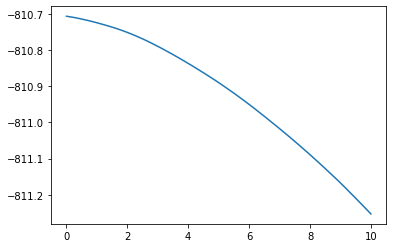

In [40]:
import matplotlib.pyplot as plt
plt.plot(alpha, error)

### Batch gradient descent

In [23]:
from sklearn.linear_model import SGDRegressor
sgd_reg  = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.01)
sgd_reg.fit(X_train,y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [24]:
model_eval = model_performance(sgd_reg)
model_eval.print_metrics(X_train, y_train)

RMSE: 1226.214678478257
R2: 0.9518869861496637

Cross_validation:
Mean: 1229.5729421658693
SD: 33.07360254689887


### Random Forest Regressor

In [40]:
rr  = RandomForestRegressor()
rr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [41]:
model_eval = model_performance(rr)
model_eval.print_metrics(X_train, y_train)

RMSE: 207.01392008619493
R2: 0.9986608037854329

Cross_validation:
Mean: 560.1283890429517
SD: 14.773184918464032


### Random forest performs the best. I will try to further improve the model by testing different hyperparameters using GridSearchCV

In [44]:
for name, score in zip(X_train.columns, rr.feature_importances_):
    print(name, score)

carat 0.5893463630240355
lenght_x 0.006211049220298699
width_y 0.29942714789294694
depth_z 0.007587808756666551
cut 0.001948989163202766
color 0.03244782684387205
clarity 0.06303081509897747


In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 50, 100, 500], 'max_features': ['auto', 'sqrt', 'log2']}    
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                          scoring='neg_mean_squared_error',
                          return_train_score=True,
                          n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [46]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [47]:
cvres = grid_search.cv_results_

In [48]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

646.063037200085 {'max_features': 'auto', 'n_estimators': 3}
586.7601349267304 {'max_features': 'auto', 'n_estimators': 10}
569.9196691924259 {'max_features': 'auto', 'n_estimators': 30}
564.058370165919 {'max_features': 'auto', 'n_estimators': 50}
562.1658703541988 {'max_features': 'auto', 'n_estimators': 100}
560.0569617220045 {'max_features': 'auto', 'n_estimators': 500}
703.3531997698924 {'max_features': 'sqrt', 'n_estimators': 3}
610.7276959937785 {'max_features': 'sqrt', 'n_estimators': 10}
585.2899640764643 {'max_features': 'sqrt', 'n_estimators': 30}
576.3164715282437 {'max_features': 'sqrt', 'n_estimators': 50}
572.5548027539171 {'max_features': 'sqrt', 'n_estimators': 100}
569.7421676265691 {'max_features': 'sqrt', 'n_estimators': 500}
708.6600286658614 {'max_features': 'log2', 'n_estimators': 3}
612.7473172366757 {'max_features': 'log2', 'n_estimators': 10}
584.4907084929786 {'max_features': 'log2', 'n_estimators': 30}
579.0737857100241 {'max_features': 'log2', 'n_estimators

In [80]:
import xgboost

ModuleNotFoundError: No module named 'xgboost'

In [41]:
alphas = np.logspace(-10, 1, 400)

In [47]:
alphas

array([1.00000000e-10, 1.06553795e-10, 1.13537112e-10, 1.20978102e-10,
       1.28906759e-10, 1.37355044e-10, 1.46357012e-10, 1.55948950e-10,
       1.66169525e-10, 1.77059935e-10, 1.88664080e-10, 2.01028738e-10,
       2.14203749e-10, 2.28242224e-10, 2.43200751e-10, 2.59139630e-10,
       2.76123110e-10, 2.94219653e-10, 3.13502206e-10, 3.34048498e-10,
       3.55941352e-10, 3.79269019e-10, 4.04125533e-10, 4.30611093e-10,
       4.58832461e-10, 4.88903400e-10, 5.20945127e-10, 5.55086803e-10,
       5.91466054e-10, 6.30229527e-10, 6.71533479e-10, 7.15544407e-10,
       7.62439721e-10, 8.12408458e-10, 8.65652043e-10, 9.22385104e-10,
       9.82836333e-10, 1.04724941e-09, 1.11588399e-09, 1.18901674e-09,
       1.26694246e-09, 1.34997528e-09, 1.43844989e-09, 1.53272295e-09,
       1.63317447e-09, 1.74020937e-09, 1.85425913e-09, 1.97578347e-09,
       2.10527227e-09, 2.24324750e-09, 2.39026535e-09, 2.54691844e-09,
       2.71383825e-09, 2.89169765e-09, 3.08121359e-09, 3.28315001e-09,
      

In [43]:
from sklearn.linear_model import RidgeCV
regr_cv = RidgeCV(alphas=alphas)

In [44]:
model_cv = regr_cv.fit(X_test, y_test)

In [45]:
model_cv.alpha_

0.44578228604196973

In [46]:
model_eval = model_performance(model_cv)
model_eval.print_metrics(X_train, y_train)

RMSE: 1225.5845721580035
R2: 0.9519376684136798

Cross_validation:
Mean: 1223.7545097010793
SD: 33.270977215167
